Cleaner verison with all the light curves made. Will try to fit the white dwarf Teff

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from astropy.modeling import models, fitting



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [59]:
path = '/media/david/1tb_storage1/emergency_data/carmenes_binary/'

In [60]:
mods = glob.glob('{}models_1628872352/koester2/*.dat.txt'.format(path))
# mods

In [61]:
d_gj176 = 1/(105.42748417135273e-3)*u.pc
d_gj207 = 1/(63.35970667464679e-3)*u.pc
rwd = 0.0128*u.Rsun

gj_scale = (d_gj176/d_gj207)**2
wd_scale = (rwd.to(u.m)/d_gj207.to(u.m))**2

print(gj_scale, wd_scale)

0.36117578882221896 3.3434064163686346e-22


In [62]:
data = fits.getdata('{}/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits'.format(path))
# data = fits.getdata('{}/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_var-res-sed.fits'.format(path))
gw, gf = data['WAVELENGTH'], data['FLUX']

In [63]:
xsfiles = glob.glob('{}xshooter/*'.format(path))
# fits.getheader(xsfiles[0])
bfiles = []
for x in xsfiles:
    if fits.getheader(x)['DISPELEM'] == 'UVB':
        bfiles.append(x)
d1 = fits.getdata(bfiles[1], 0)[0]
xw, xf, xe, dq = d1['WAVE'], d1['FLUX'],d1['ERR'], d1['QUAL']
mask = (dq ==0) & (xw > 310)
xw, xf, xe = xw[mask]*10, xf[mask], xe[mask]
# plt.plot(xw, xf)

In [64]:
spath = '{}swift/working/gj207-1_uvw2_100slc.fits'.format(path)
data = fits.getdata(spath, 1)
t, f, e = data['TIME'], data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
t1, f1, e1 = t[:6], f[:6], e[:6]
swift_flux = np.average(f1, weights = 1/(e1**2))
swift_error =  (1 / np.sum(1/(e1**2)))**0.5
print(swift_flux, swift_error)
swift_wave = 2054.61 #lambda_ref
print(swift_flux/swift_error)

1.994796e-15 6.560634234084285e-17
30.405536681526673


In [65]:
swiftpath = '/home/david/work/filters/uvot/'


uvw2path = '/home/david/work/filters/uvot/Swift_UVOT.UVW2.dat'
uvw2bw, uvw2bp = np.loadtxt(uvw2path, unpack=True)

upath = '/home/david/work/filters/uvot/Swift_UVOT.U.dat'
ubw, ubp = np.loadtxt(upath, unpack=True)

In [66]:
def make_phot(bp_w, bp_cc, w, f):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

In [67]:
nuv= Table.read('galex/gj207-1_nuv_10.0s_lc.csv')

t, f, e, q = nuv['t_mean'], nuv['flux_bgsub'], nuv['flux_bgsub_err'], nuv['flags']
t, f, e = t[q==0], f[q==0], e[q==0]
galex_flux = np.average(f, weights = 1/(e**2))
# galex_flux = 1.2e-15 #cataloge value
galex_error =  (1 / np.sum(1/(e**2)))**0.5
print(galex_flux, galex_error)
galex_wave = 2300.79
gbw, gbp = np.loadtxt('../filters/galex/GALEX_GALEX.NUV.dat', unpack=True)
print(gbw[0], uvw2bw[0], ubw[-1])

1.0049178765233773e-15 1.0487355277243325e-16
1690.0 1597.495 4882.495


In [68]:
uphot = make_phot(ubw, ubp, xw, xf)
uwave = 3467.05
uerror= 0.1*uphot
print(uphot)

1.0242704244846745e-14


In [69]:
phot_w = np.array([swift_wave, galex_wave, uwave])
phot_f = np.array([swift_flux, galex_flux, uphot])
phot_e = np.array([swift_error, galex_error, uerror])

In [70]:
gw1, gf1 = gw[(gw > 1500) & (gw < 6000)], gf[(gw > 1500) & (gw < 6000)]*gj_scale

3100.2000000000003


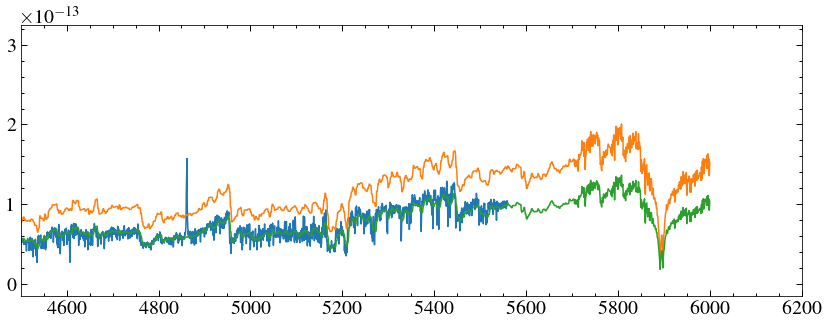

In [71]:
plt.plot(xw, xf)#convolve(xf, Box1DKernel(20)))
plt.plot(gw1, gf1)
print(xw[0])

#scale the first band 
plt.xlim(4500, 6200)
xmask = (xw > 5000) & (xw < 5200)
gmask = (gw1 > 5000) & (gw1 < 5200)

scale2 = np.trapz(gf1[gmask], gw1[gmask]/np.trapz(xf[xmask], xw[xmask]))
plt.plot(gw1, gf1/scale2)

gf1 = gf1/scale2

In [72]:
# nowd_w, nowd_f = np.concatenate((gw1, xw)), np.concatenate((gf1, xf)) #can't do that as the x shooter data might include a wd
nowd_w, nowd_f = gw1, gf1

<ErrorbarContainer object of 3 artists>

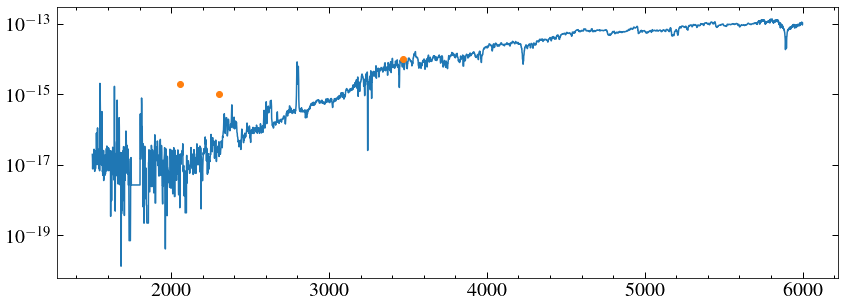

In [73]:
plt.plot(nowd_w, nowd_f)
plt.yscale('log')
plt.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none')

In [74]:
pw = np.arange(nowd_w[0], nowd_w[-1], 1)
# plt.figure()
# for model in mods:
#     mw, mf = np.loadtxt(model, unpack=True)
#     mw1, mf1 = mw[(mw > nowd_w[0]) & (mw < nowd_w[-1])], mf[(mw > nowd_w[0]) & (mw < nowd_w[-1])]*wd_scale
#     pf = interp1d(mw1, mf1, fill_value = 'extrapolate')(pw) +  interp1d(nowd_w, nowd_f, fill_value = 'extrapolate')(pw)
#     plt.plot(pw, pf)
# plt.yscale('log')
# plt.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none')
# plt.ylim(1.1e-17, 5e-14)
# plt.xlim(1501, 3999)

In [75]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    http://learn.astropy.org/rst-tutorials/User-Defined-Model.html
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

from scipy.stats import chisquare

In [76]:
# teffs = []
# rchi2 = []
# for model in mods:
#     teff = model[-20:-15]
#     teffs.append(float(teff))
#     mw, mf = np.loadtxt(model, unpack=True)
#     mw1, mf1 = mw[(mw > nowd_w[0]) & (mw < nowd_w[-1])], mf[(mw > nowd_w[0]) & (mw < nowd_w[-1])]*wd_scale
#     pf = interp1d(mw1, mf1, fill_value = 'extrapolate')(pw) +  interp1d(nowd_w, nowd_f, fill_value = 'extrapolate')(pw)
#     s_mod = make_phot(uvw2bw, uvw2bp, pw, pf)
#     g_mod = make_phot(gbw, gbp, pw, pf)
#     u_mod = make_phot(ubw, ubp, pw, pf)
#     synphot = np.array([s_mod, g_mod, u_mod])
# #     synphot = np.array([s_mod, g_mod])
#     syn_e = (synphot * phot_e) / phot_f**2
#     plt.errorbar(phot_w, synphot/phot_f, yerr=syn_e, marker = 'o', ls = '--', label=teff)
#     rX2 = calc_reduced_chi_square(synphot, phot_w, phot_f, phot_e, len(synphot), 1)
# #     print(rX2)
#     rchi2.append(rX2)
# plt.axhline(1, ls='--', c='0.5')
# plt.legend()
# #     plt.plot(pw, pf)

In [77]:
# plt.scatter(teffs, rchi2)

In [78]:
# teffs2 = np.arange(5000, 9000, 100)
# rchi22 = []
# chi2 = []
# mw, mf85 = np.loadtxt(mods[0], unpack=True)
# mw9, mf9 = np.loadtxt(mods[16], unpack=True)
# mf9 = interp1d(mw9, mf9, fill_value = 'extrapolate')(mw)
# for t in teffs2:
#     mf = interp1d([5000, 9000], [mf85, mf9], axis=0, fill_value = 'extrapolate')(t)
#     mw1, mf1 = mw[(mw > nowd_w[0]) & (mw < nowd_w[-1])], mf[(mw > nowd_w[0]) & (mw < nowd_w[-1])]*wd_scale
#     pf = interp1d(mw1, mf1, fill_value = 'extrapolate')(pw) +  interp1d(nowd_w, nowd_f, fill_value = 'extrapolate')(pw)
#     s_mod = make_phot(uvw2bw, uvw2bp, pw, pf)
#     g_mod = make_phot(gbw, gbp, pw, pf)
#     u_mod = make_phot(ubw, ubp, pw, pf)
#     synphot = np.array([s_mod, g_mod, u_mod])
# #     synphot = np.array([s_mod, g_mod])
#     syn_e = (synphot * phot_e) / phot_f**2
# #     plt.errorbar(phot_w, synphot/phot_f, yerr=phot_f, marker = 'o', ls = '--', label=teff)
#     rX2 = calc_reduced_chi_square(synphot, phot_w, phot_f, phot_e, len(synphot), 1)
# #     print(rX2)
#     rchi22.append(rX2)
#     X2 = chisquare(synphot, f_exp=phot_f, ddof=1, axis=0)
#     chi2.append(X2[0])
# # plt.axhline(1, ls='--', c='0.5')
# # plt.legend()
# plt.scatter(teffs2, rchi22)

In [79]:
# mw85, mf85 = np.loadtxt(models[6], unpack=True)
# mw9, mf9 = np.loadtxt(models[8], unpack=True)
# mf9 = interp1d(mw9, mf9, fill_value = 'extrapolate')(mw85)
# plt.plot(mw85, mf85, c='k')
# plt.plot(mw85, mf9, c='k')
# trange = np.arange(8510, 9000, 10)
# for t in trange:
#     mwt = interp1d([8500, 9000], [mf85, mf9], axis=0, fill_value = 'extrapolate')(t)
#     plt.plot(mw85, mwt)
# plt.xlim(1500, 3000)
# plt.ylim(3e7, 7e7)

In [80]:
# fitter = fitting.LevMarLSQFitter()

# # plt.scatter(teffs, rchi2)
# plt.scatter(teffs2, rchi22)
# gg_init = models.Const1D(500)- models.Gaussian1D(-100, 8600, 1000)
# gg_fit = fitter(gg_init, np.array(teffs2), np.array(rchi22), maxiter=100000)
# print(fitter.fit_info['message'])
# # fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
# print(gg_fit)
# # print(fit_e)
# plt.plot(teffs, gg_fit(teffs), c='C1')

Try fitting to just uv, in mean time 8600 looks good

In [81]:
# mf8s = interp1d([7000, 9500], [mf85, mf9], axis=0, fill_value = 'extrapolate')(8000)
# plt.plot(mw, mf8s)
# mw8, mf8 = np.loadtxt(mods[4], unpack=True)
# plt.plot(mw8, mf8)

Need finer resolution. Let's just make the best fit

In [82]:
# mods

/media/david/1tb_storage1/emergency_data/carmenes_binary/models_1628872352/koester2/da06500_800.dk.dat.txt


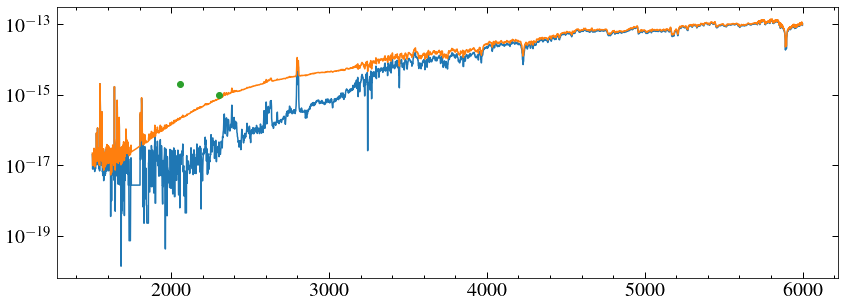

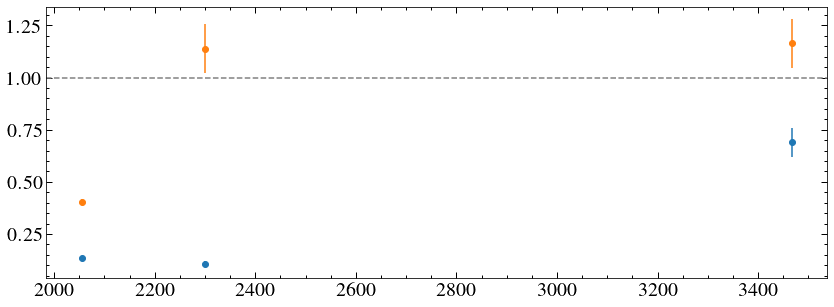

In [83]:
#just add the 8000K

# mw, mf85 = np.loadtxt(mods[6], unpack=True)
# mw875, mf875 = np.loadtxt(mods[7], unpack=True)
# mf875 = interp1d(mw875, mf875, fill_value = 'extrapolate')(mw)
# mf = interp1d([8500, 8750], [mf85, mf875], axis=0, fill_value = 'extrapolate')(8630)
nowd_w, nowd_f = gw1, gf1

modn = 6
print(mods[modn])
mw, mf = np.loadtxt(mods[modn], unpack=True)
mw1, mf1 = mw[(mw > nowd_w[0]) & (mw < nowd_w[-1])], mf[(mw > nowd_w[0]) & (mw < nowd_w[-1])]*wd_scale
pf = interp1d(mw1, mf1, fill_value = 'extrapolate')(pw) +  interp1d(nowd_w, nowd_f, fill_value = 'extrapolate')(pw)


# making the emmsion lines brighter
model_lines = [1810]#[2796.35, 2803.53]
lines_model = models.Const1D(0)
for line in model_lines:
    lines_model = lines_model+models.Gaussian1D(4e-13, line, 1)
    
# nowd_f = nowd_f + lines_model(nowd_w)
# pf = pf+ lines_model(pw)


s_mod = make_phot(uvw2bw, uvw2bp, pw, pf)
g_mod = make_phot(gbw, gbp, pw, pf)
u_mod = make_phot(ubw, ubp, pw, pf)
synphot_wd = np.array([s_mod, g_mod, u_mod])
synwd_e = (synphot_wd * phot_e) / phot_f**2

s_mod = make_phot(uvw2bw, uvw2bp, nowd_w, nowd_f)
g_mod = make_phot(gbw, gbp, nowd_w, nowd_f)
u_mod = make_phot(ubw, ubp, nowd_w, nowd_f)
synphot_nwd = np.array([s_mod, g_mod, u_mod])
synnwd_e = (synphot_nwd * phot_e) / phot_f**2




plt.plot(nowd_w, nowd_f)
plt.plot(pw,pf)
plt.yscale('log')
plt.errorbar(phot_w[:-1], phot_f[:-1], yerr=phot_e[:-1], marker='o', ls='none')
plt.show()

plt.errorbar(phot_w, synphot_nwd/phot_f, yerr=synnwd_e, marker='o', ls='none')
plt.errorbar(phot_w, synphot_wd/phot_f, yerr=synwd_e, marker='o', ls='none')
plt.axhline(1, ls='--', c='0.5')

plt.show()

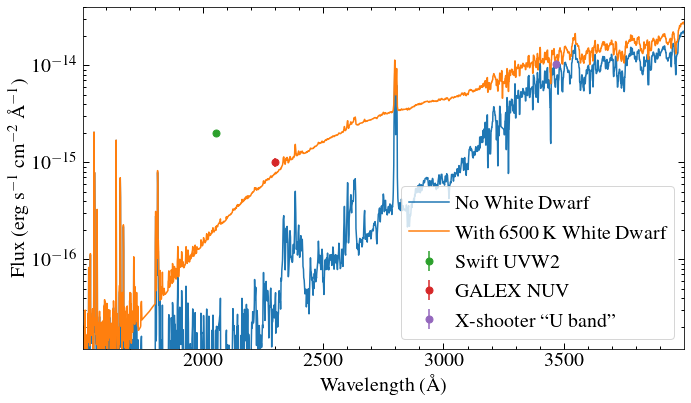

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(nowd_w[(nowd_w < 3240) | (nowd_w > 3250)] , nowd_f[(nowd_w < 3240) | (nowd_w > 3250)], label = 'No White Dwarf')
# plt.plot(mw1, mf1)
plt.plot(pw, pf, label='With 6500\,K White Dwarf')

plt.errorbar(swift_wave, swift_flux, yerr=swift_error, marker='o', ls='none', label = 'Swift UVW2',ms=7)
plt.errorbar(galex_wave, galex_flux, yerr=galex_error, marker='o', ls='none', label='GALEX NUV', ms=7)
plt.errorbar(uwave, uphot, yerr=uerror, marker='o', ls='none', label = 'X-shooter ``U band"',ms=7)
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=4, frameon=True)
plt.xlim(1501, 3999)
plt.ylim(1.2e-17, 4e-14)
plt.tight_layout()
plt.savefig('plots/gj207-1_best_fit.png', dpi=150)
plt.savefig('plots/gj207-1_best_fit.pdf', dpi=150)

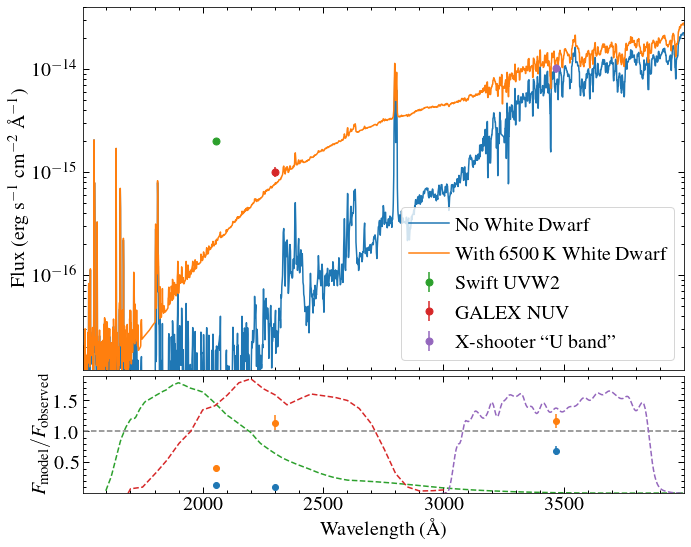

In [107]:
plt.figure(figsize=(10, 8))
gs = GridSpec(4, 1)
xlims = (1501, 3999)
plt.subplot(gs[:3])
plt.plot(nowd_w[(nowd_w < 3240) | (nowd_w > 3250)] , nowd_f[(nowd_w < 3240) | (nowd_w > 3250)], label = 'No White Dwarf')
# plt.plot(mw1, mf1)
plt.plot(pw, pf, label='With 6500\,K White Dwarf')
plt.errorbar(swift_wave, swift_flux, yerr=swift_error, marker='o', ls='none', label = 'Swift UVW2',ms=7)
plt.errorbar(galex_wave, galex_flux, yerr=galex_error, marker='o', ls='none', label='GALEX NUV', ms=7)
plt.errorbar(uwave, uphot, yerr=uerror, marker='o', ls='none', label = 'X-shooter ``U band"',ms=7)
plt.yscale('log')
# plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=4, frameon=True)
plt.xlim(xlims[0], xlims[1])
plt.ylim(1.2e-17, 4e-14)
plt.xticks(visible=False)


plt.subplot(gs[3:])
plt.errorbar(phot_w, synphot_nwd/phot_f, yerr=synnwd_e, marker='o', ls='none')
plt.errorbar(phot_w, synphot_wd/phot_f, yerr=synwd_e, marker='o', ls='none')
plt.ylim(0.01, 1.9)
plt.xlim(xlims[0], xlims[1])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('$F_{\mathrm{model}}/F_{\mathrm{observed}}$')
plt.axhline(1, ls='--', c='0.5')

plt.plot(uvw2bw, uvw2bp/15, ls='--')
plt.plot(gbw, gbp*3, ls='--')
plt.plot(ubw, ubp/30, ls='--')


plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/gj207-1_phot.png', dpi=150, facecolor ='w')
plt.savefig('plots/gj207-1_phot.pdf', dpi=150)

In [86]:
# #detlev has me concerned that the scaling is wrong...
# w,f,e, dq=np.loadtxt('../gd394/observations/201808_spectra/GD-394_STIS_FUV-MAMA_E140M_201808coadd.dat', unpack=True)
# mask=(w>1160.) & (dq == 0) & (f >1E-14)
# w,f,e=w[mask], f[mask], e[mask]
# plt.plot(w,f)
# mw_uv, mf_uv = np.loadtxt('../gd394/odette/gd394_full_span.dk', unpack=True)
# mask = (mw_uv > w[0]) & (mw_uv < w[-1])
# mw, mf = mw_uv[mask], mf_uv[mask]
# d394 = 50.37*u.pc
# r394 = 0.013*u.Rsun
# scale = (np.pi*r394.to(u.m)**2/d394.to(u.m)**2)*1e-8
# plt.plot(mw, mf*scale)

# #svo model
# mw1, mf1 = np.loadtxt('{}da36000_800.dk.dat.txt'.format(path), unpack=True)
# mask = (mw1 > w[0]) & (mw1 < w[-1])
# mw1, mf1 = mw1[mask], mf1[mask]
# scale1 = (r394.to(u.m)/d394.to(u.m))**2
# plt.plot(mw1, mf1*scale1)

# #oh no.
# #guess I'll redo everything...

X-ray flux is bright - what if CV? Emission lines look like M dwarf only.

In [87]:
# xsfiles = glob.glob('{}xshooter/*'.format(path))
# # fits.getheader(xsfiles[0])
# for x in xsfiles:
#     if fits.getheader(x)['INSTRUME'] != 'HARPS':
#         d1 = fits.getdata(x, 1)
#         xw, xf, xe, dq = d1['WAVE'], d1['FLUX'], d1['ERR'], d1['QUAL']
#         mask = (dq ==0) & (xw > 310) & (xf > 0)
#         xw, xf = xw[mask]*10, xf[mask]
#         if xw[0] > 5000:
#             mask = xw > 5500
#             xw, xf = xw[mask], xf[mask]
#         # xw, xf = xw[dq==0], xf[dq==0]
#         plt.plot(xw, xf)
# plt.xlim(6550, 6570)

2021101- X-rays! Fitted an Apec model to the XRT data, I think.

In [128]:
xrt = np.loadtxt('{}swift/xrt/all/spectrum/gj207-1_xspec_both.txt'.format(path), skiprows=3)
xrt = xrt[::-1]


2.4828563812880228e-12


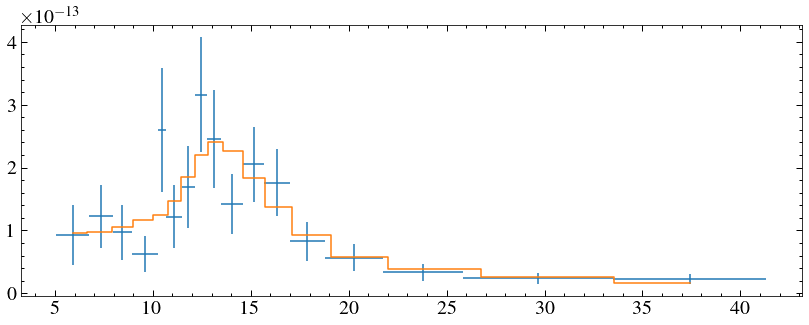

In [129]:
wx = xrt[:,0]
bx = xrt[:,1]
fx = xrt[:,2]*1.99e-8/wx
ex = xrt[:,3]*1.99e-8/wx
mx = xrt[:,4]*1.99e-8/wx

plt.errorbar(wx, fx, yerr=ex, xerr=bx, ls='none')
plt.step(wx, mx, where='mid')
print(np.trapz(mx, wx))

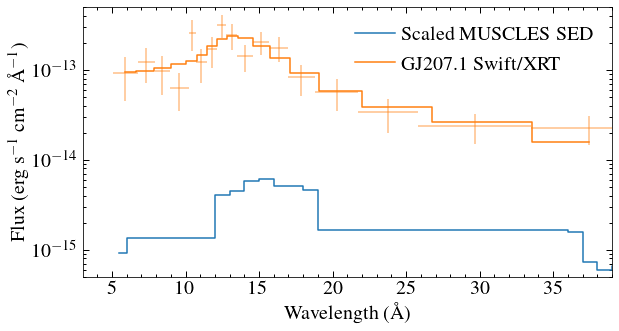

In [130]:
plt.figure(figsize=(9, 5))
plt.step(gw, gf*scale2, where='mid', label='Scaled MUSCLES SED')
plt.xlim(3, 39)
plt.step(wx, mx, where='mid', label = 'GJ207.1 Swift/XRT')
plt.errorbar(wx, fx, yerr=ex, xerr=bx, ls='none', c='C1', alpha=0.5)

plt.ylim(5e-16, 5e-13)
plt.yscale('log')
plt.legend()
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlabel('Wavelength (\AA)')
plt.tight_layout()
plt.savefig('plots/gj207-1_xrt.png', dpi=150, facecolor='w')
plt.savefig('plots/gj207-1_xrt.pdf', dpi=150)
# print(np.trapz((gf*scale2)[gw < 41], gw[gw< 41]))

In [91]:
# def xspec_to_spec(path):
#     """
#     Converts an xspec wdata textfile from counts to ergs. 
#     Assumes that the wavelength array is in Angstrom and the flux arrays are in counts/s/cm2/A
#     """
#     xrt = np.loadtxt(path, skiprows=3)
#     xrt = xrt[::-1]
#     wx = xrt[:,0]
#     bx = xrt[:,1]
#     fx = xrt[:,2]*1.99e-8/wx
#     ex = xrt[:,3]*1.99e-8/wx
#     if len(xrt[0]) == 5: #i.e. if there's a model
#         mx = xrt[:,4]*1.99e-8/wx
#         return wx, bx, fx, ex, mx
#     else:
#         return wx, bx, fx, ex
        

        
def xspec_to_spec(path):
    """
    Converts an xspec wdata textfile from counts to ergs. 
    Assumes that the wavelength array is in Angstrom and the flux arrays are in counts/s/cm2/A
    """
    xrt = np.loadtxt(path, skiprows=3)
    xrt = xrt[::-1]
    wx = xrt[:,0]*u.AA
    bx = xrt[:,1]*u.AA
    fx  = (xrt[:,2] * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
    ex  = xrt[:,3] * (u.photon/u.s/u.cm**2/u.AA).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
    if len(xrt[0]) == 5: #i.e. if there's a model
        mx  = xrt[:,4] * (u.photon/u.s/u.cm**2/u.AA).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
        return wx, bx, fx, ex, mx
    else:
        return wx, bx, fx, ex
        
        

In [92]:
wx, bx, fx, ex, mx = xspec_to_spec('{}swift/xrt/spectrum/gj207_1_xspec2.txt'.format(path))
print(fx)

[1.23336727e-13 8.70698856e-14 9.62706571e-14 2.35133959e-13
 1.36268539e-13 2.04728941e-13 2.40521404e-13 1.78276699e-13
 6.20865383e-14 3.54840140e-14 2.53665522e-14] erg / (Angstrom cm2 s)


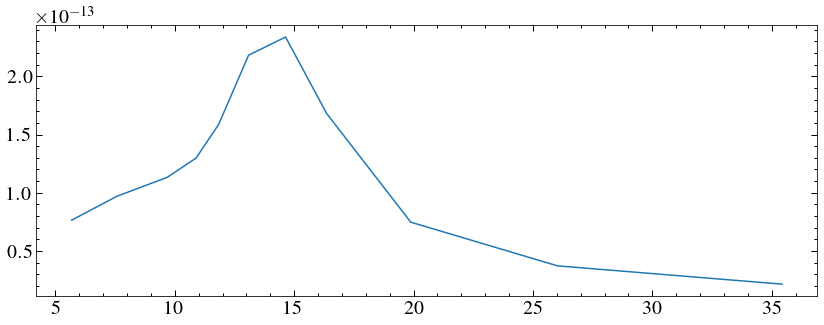

In [93]:
wx, bx, fx, ex, mx = xspec_to_spec('{}swift/xrt/spectrum/gj207_1_xspec2.txt'.format(path))
plt.plot(wx, mx)

(3913.6614, 3988.4673)

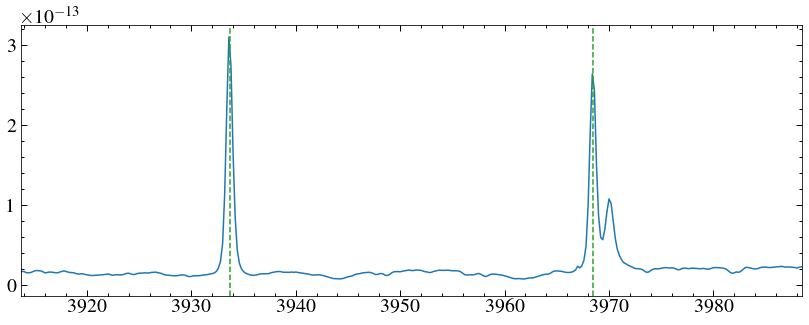

In [94]:
plt.plot(xw, xf)
ca =[ 3933.6614, 3968.4673]
[plt.axvline(line, c='C2', ls='--') for line in ca]
plt.xlim(ca[0]-20, ca[1]+20)

Could estimate Mg ii line strength from KM relationships? Seconnd Swift observation has come through!

In [95]:
swift_flux2 = 2.02e-15
swift_error2 = ((0.08**2 +0.04**2)**0.5) * 1e-15

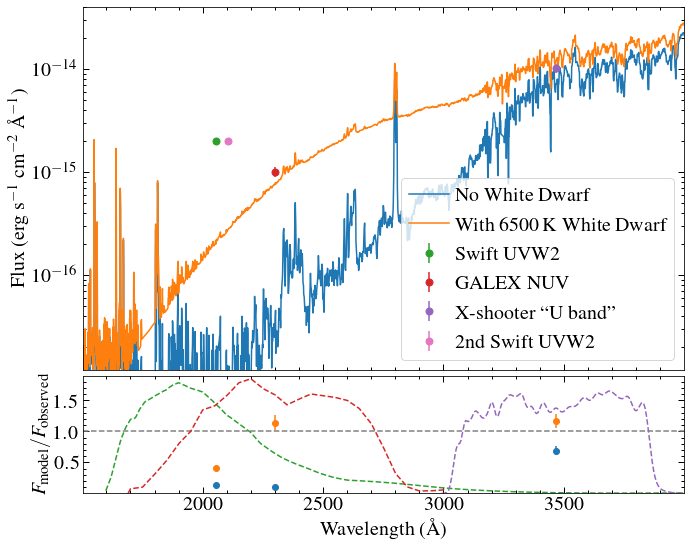

In [96]:
plt.figure(figsize=(10, 8))
gs = GridSpec(4, 1)
xlims = (1501, 3999)
plt.subplot(gs[:3])
plt.plot(nowd_w[(nowd_w < 3240) | (nowd_w > 3250)] , nowd_f[(nowd_w < 3240) | (nowd_w > 3250)], label = 'No White Dwarf')
# plt.plot(mw1, mf1)
plt.plot(pw, pf, label='With 6500\,K White Dwarf')
plt.errorbar(swift_wave, swift_flux, yerr=swift_error, marker='o', ls='none', label = 'Swift UVW2',ms=7)
plt.errorbar(galex_wave, galex_flux, yerr=galex_error, marker='o', ls='none', label='GALEX NUV', ms=7)
plt.errorbar(uwave, uphot, yerr=uerror, marker='o', ls='none', label = 'X-shooter ``U band"',ms=7)

plt.errorbar(swift_wave+50, swift_flux2, yerr=swift_error2, marker='o', ls='none', label = '2nd Swift UVW2',ms=7, c='C6')


plt.yscale('log')
# plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=4, frameon=True)
plt.xlim(xlims[0], xlims[1])
plt.ylim(1.2e-17, 4e-14)
plt.xticks(visible=False)


plt.subplot(gs[3:])
plt.errorbar(phot_w, synphot_nwd/phot_f, yerr=synnwd_e, marker='o', ls='none')
plt.errorbar(phot_w, synphot_wd/phot_f, yerr=synwd_e, marker='o', ls='none')
plt.ylim(0.01, 1.9)
plt.xlim(xlims[0], xlims[1])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('$F_{\mathrm{model}}/F_{\mathrm{observed}}$')
plt.axhline(1, ls='--', c='0.5')

plt.plot(uvw2bw, uvw2bp/15, ls='--')
plt.plot(gbw, gbp*3, ls='--')
plt.plot(ubw, ubp/30, ls='--')


plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/gj207-1_phot2.png', dpi=150)
plt.savefig('plots/gj207-1_phot2.pdf', dpi=150)

In [97]:
print((swift_flux/swift_flux2)*100)
print((swift_error/swift_flux)*100)
print((swift_error2/swift_flux2)*100)

98.75227963293534
3.288874689087677
4.427857381187702


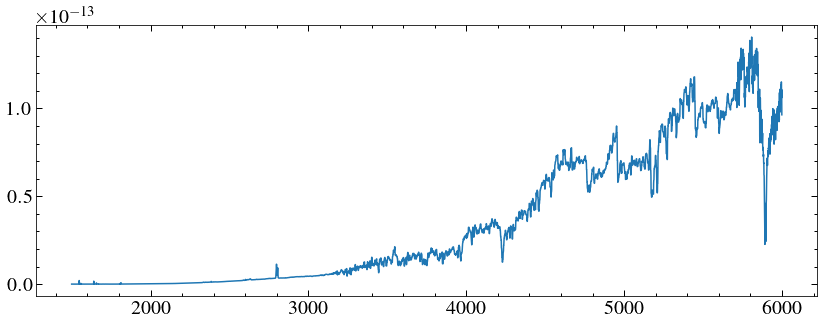

In [98]:
plt.plot(pw, pf)

In [99]:
#save a model for hst etc
savdat = Table([pw, pf], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'gj207_model.dat', format='basic')

In [100]:
1.2e-11/u.um.to(u.AA) 

1.2000000000000004e-15

In [101]:
galex_flux/1.2e-15

0.8374315637694811

1.0699514953121089e-14
2.6303357295793814e-15


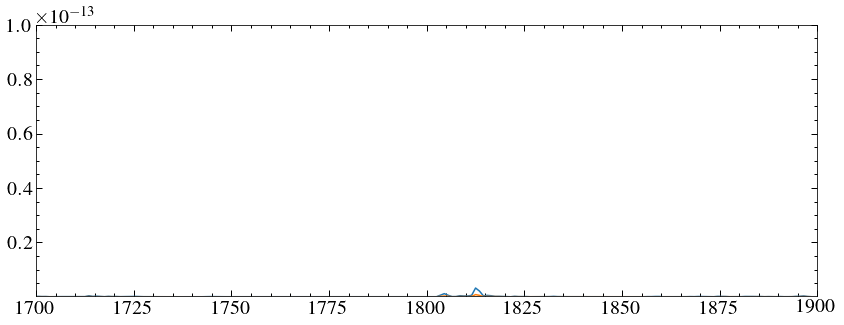

In [102]:
plt.plot(gw, gf)
plt.xlim(1700, 1900)
plt.ylim(1e-16, 1e-13)
plt.plot(nowd_w, nowd_f)

print(np.trapz(gf[(gw > 1800) & (gw < 1820)], gw[(gw > 1800) & (gw < 1820)]))
print(np.trapz(nowd_f[(nowd_w > 1800) & (nowd_w < 1820)], nowd_w[(nowd_w > 1800) & (nowd_w < 1820)]))
# plt.yscale('log')

Making emmsion lines brighter

In [103]:
wddms = Table.read('wddms_mass_table.txt', format='ascii.basic')

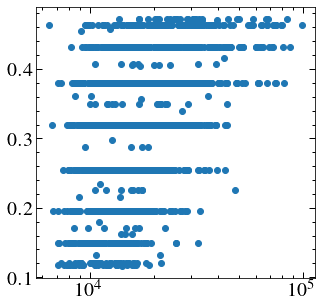

In [104]:
wddms = wddms[wddms['Teffwd'] < 100000]
plt.figure(figsize=(5,5))
plt.scatter(wddms['Teffwd'], wddms['M2'])
plt.xscale('log')

/media/david/1tb_storage1/emergency_data/carmenes_binary/xshooter/ADP.2017-05-12T10 10 12.423.fits
/media/david/1tb_storage1/emergency_data/carmenes_binary/xshooter/ADP.2017-05-12T10 12 41.244.fits
/media/david/1tb_storage1/emergency_data/carmenes_binary/xshooter/ADP.2017-05-12T10 12 41.326.fits


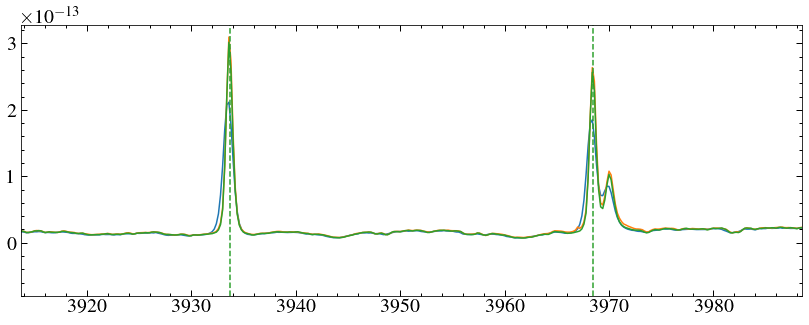

/media/david/1tb_storage1/emergency_data/carmenes_binary/xshooter/ADP.2017-05-12T10 10 12.378.fits
/media/david/1tb_storage1/emergency_data/carmenes_binary/xshooter/ADP.2017-05-12T10 12 41.256.fits
/media/david/1tb_storage1/emergency_data/carmenes_binary/xshooter/ADP.2017-05-12T10 12 41.291.fits


(6542.8, 6582.8)

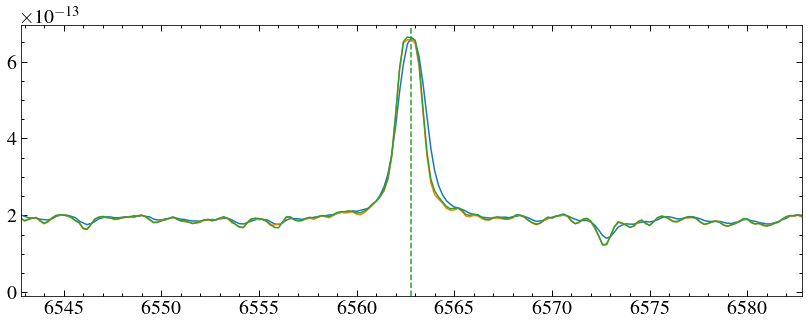

In [105]:
# xsfiles = glob.glob('{}xshooter/*'.format(path))
# fits.getheader(xsfiles[0])
bfiles = []
vfiles = []
for x in xsfiles:
    if fits.getheader(x)['DISPELEM'] == 'UVB':
        bfiles.append(x)
    elif fits.getheader(x)['DISPELEM'] == 'VIS':
        vfiles.append(x)
for x in bfiles:
    print(x)
    xdata = fits.getdata(x, 0)[0]
    xw, xf, xe, dq = xdata['WAVE'], xdata['FLUX'],xdata['ERR'], xdata['QUAL']
    mask = (dq ==0) & (xw > 310)
    xw, xf, xe = xw[mask]*10, xf[mask], xe[mask]
    plt.plot(xw, xf)
#     plt.plot(xw, xe)
    
ca =[ 3933.6614, 3968.4673]
[plt.axvline(line, c='C2', ls='--') for line in ca]
plt.xlim(ca[0]-20, ca[1]+20)

plt.show()


for x in vfiles:
    print(x)
    xdata = fits.getdata(x, 0)[0]
    xw, xf, xe, dq = xdata['WAVE'], xdata['FLUX'],xdata['ERR'], xdata['QUAL']
    mask = (dq ==0) & (xw > 550)
    xw, xf, xe = xw[mask]*10, xf[mask], xe[mask]
    plt.plot(xw, xf)
#     plt.plot(xw, xe)
    
ha = 6562.8 

plt.axvline(ha, c='C2', ls='--') 
plt.xlim(ha-20, ha+20)
# d1 = fits.getdata(bfiles[1], 0)[0]
# xw, xf, xe, dq = d1['WAVE'], d1['FLUX'],d1['ERR'], d1['QUAL']
# mask = (dq ==0) & (xw > 310)
# xw, xf, xe = xw[mask]*10, xf[mask], xe[mask]
# plt.plot(xw, xf)

So Ca H & K vary, H alpha is fairly constant. Can get EW measurements and make an estimate. Also- get a phoenix model with the gj207.1 parameters and compare it with the MM SED. If the continumn difference is small, might make more sense to use that with predicted emmison lines from Melbourne added on.

In [125]:
#Lx/Lstar  ratio

d = 15.78*u.pc
# lx=3.1757e-12*u.erg/u.cm**2/u.s
lx=3.0763e-12*u.erg/u.cm**2/u.s
lxsun = (lx*(d.to(u.cm))**2).to(u.Lsun)
lstar = (10**-1.4)*u.Lsun
print(lstar)
print(np.log10((lx*(d.to(u.cm))**2).value))
print(((lx*(d.to(u.cm))**2).value))
print(lxsun)
print(np.log10(lxsun/lstar))
print((lxsun/lstar))

0.039810717055349734 solLum
27.862943773674022
7.293630764945797e+27
1.905337190424712e-06 solLum
-4.320028155430783
4.7859906360784186e-05


Much lower than saturation? 

In [123]:
#confidence range
lx_all = 3.0763e-12
frange = np.array([-11.5763, -11.4459])
print(10**frange)

#even with errors the flux is too small 

[2.63936832e-12 3.56287019e-12]
